# Extended data data Fig 4
The notebook below generates the figures shown in extended data 4a, 4b, and 4c. 

In [1]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'avenir',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)
from scipy.signal import savgol_filter

# special imports for scaling maps!
import copy 
from mpl_toolkits.axes_grid1 import make_axes_locatable
from afrc import AnalyticalFRC


## Set up the system
First we initialize some dictionaries/lists and define a few things...

In [6]:
# read in the data!
names = ['WT','KKK_AAA']

sequences = {}
sequences['WT']      = 'TPDGLLPHHIVMTDKEKKKLVVRRLEQLFTGKISGRNMQRNQSMPSMDAP'
sequences['KKK_AAA'] = 'TPDGLLPHHIVMTDKEAAALVVRRLEQLFTGKISGRNMQRNQSMPSMDAP'

# these are used for SASA
ev = {}
full = {}
SASA_NORM = {}

# for helicity
dssp_full = {}

# for radius of gyration
rg = {}

# for each of the sequences defined as names...
for n in names:

    # read in sidechain SASA info
    ev[n] = np.loadtxt(f'data/ev/{n}/SASA_SC_mean_radius_1.40.csv')
    full[n] = np.loadtxt(f'data/full/{n}/SASA_SC_mean_radius_1.40.csv')

    # read in helicity (DSSP H)
    dssp_full[n] = np.loadtxt(f'data/full/{n}/DSSP_H.csv')

    # read in radius of gyration
    rg[n] = np.loadtxt(f'data/full/{n}/RG.csv')

# define mapping of name to color
color_set = {}
color_set['WT'] = 'black'
color_set['KKK_AAA'] = 'purple'


# calculate normalized SASA
for n in names:
    # nan_to_num converts the nan we get from a 0/0 (gly/gly)
    SASA_NORM[n] = np.nan_to_num(full[n]/ev[n],0)
    

/var/folders/2n/xtzsyspd32v6vglg_pd5gmw80000gn/T/ipykernel_50051/4005703885.py:41: RuntimeWarning: invalid value encountered in divide
  SASA_NORM[n] = np.nan_to_num(full[n]/ev[n],0)


### Change in normalized SASA from WT
Normalized SASA from WT sims minus normalized SASA from variants gives us a measure of how mutation changes per-residue SASA. 

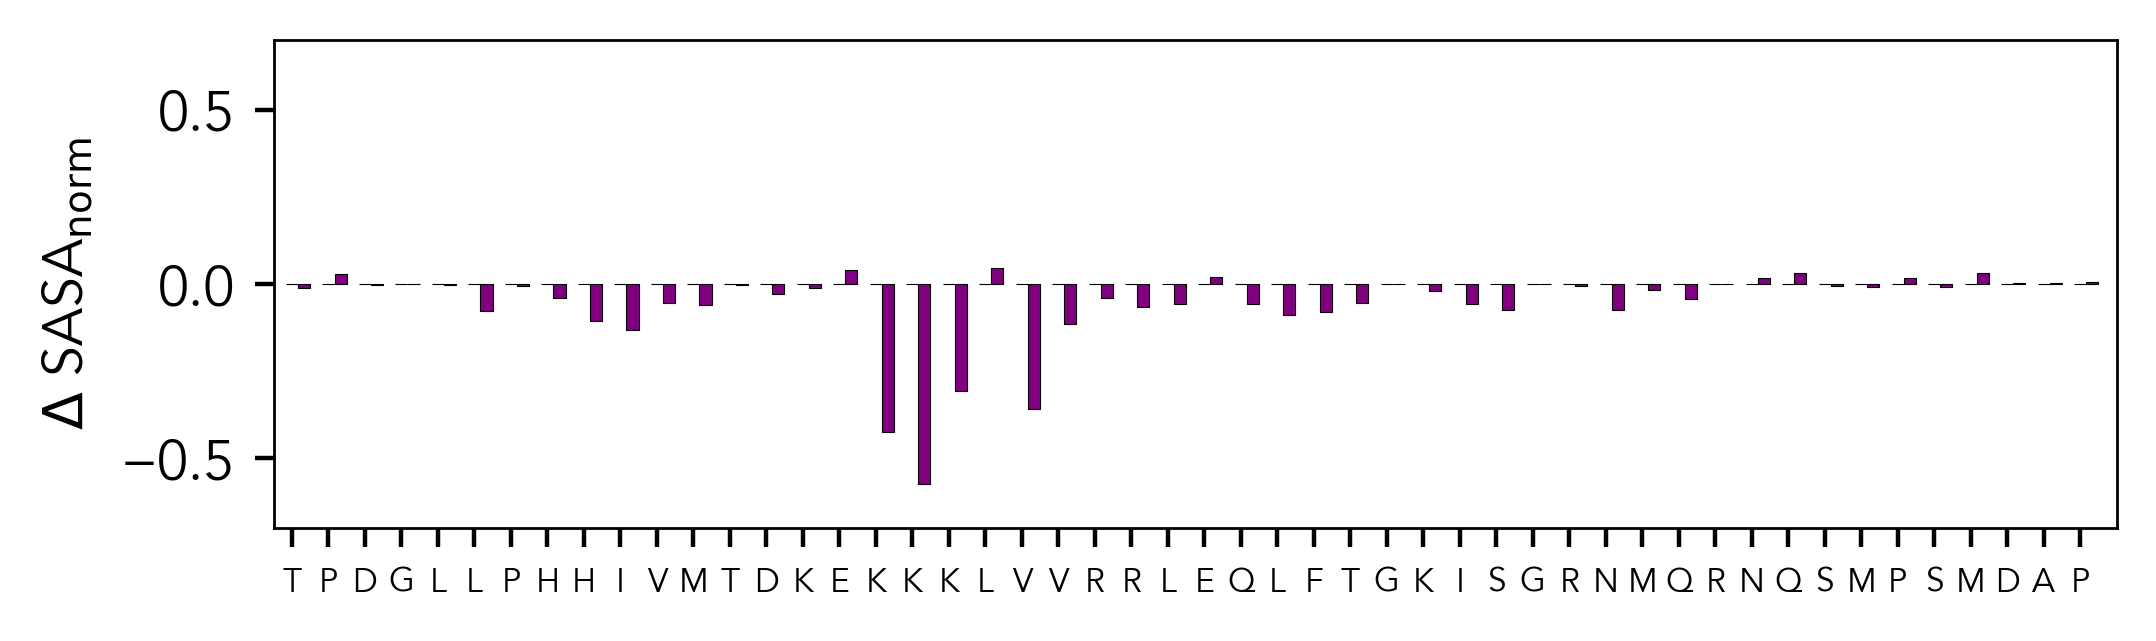

In [7]:
figure(num=None, figsize=(5.5, 1.7), dpi=200, facecolor='w', edgecolor='k')
ax = plt.gca()

offset=0
offset_stepsize=0.33
for n in names:
    residue_idx = np.arange(1,len(SASA_NORM[n])+1)
    plt.bar(residue_idx+offset, SASA_NORM[n]-SASA_NORM['WT'], width=offset_stepsize, color=color_set[n], edgecolor='k',linewidth=0.2,label=n)
    offset = offset+offset_stepsize
    
plt.ylim([-0.7,0.7])    
plt.xticks(residue_idx, 'TPDGLLPHHIVMTDKEKKKLVVRRLEQLFTGKISGRNMQRNQSMPSMDAP',fontsize=6)
print('')
#plt.legend(frameon=False,fontsize=8)
plt.xlim([1-0.5,residue_idx[-1]+1])
plt.ylabel(r'$\Delta$ SASA$_{\rm{norm}}$')
plt.tight_layout()
plt.savefig('figures/sasa_raw.pdf')



### Helicity
Per-residue helicity for the constructs.

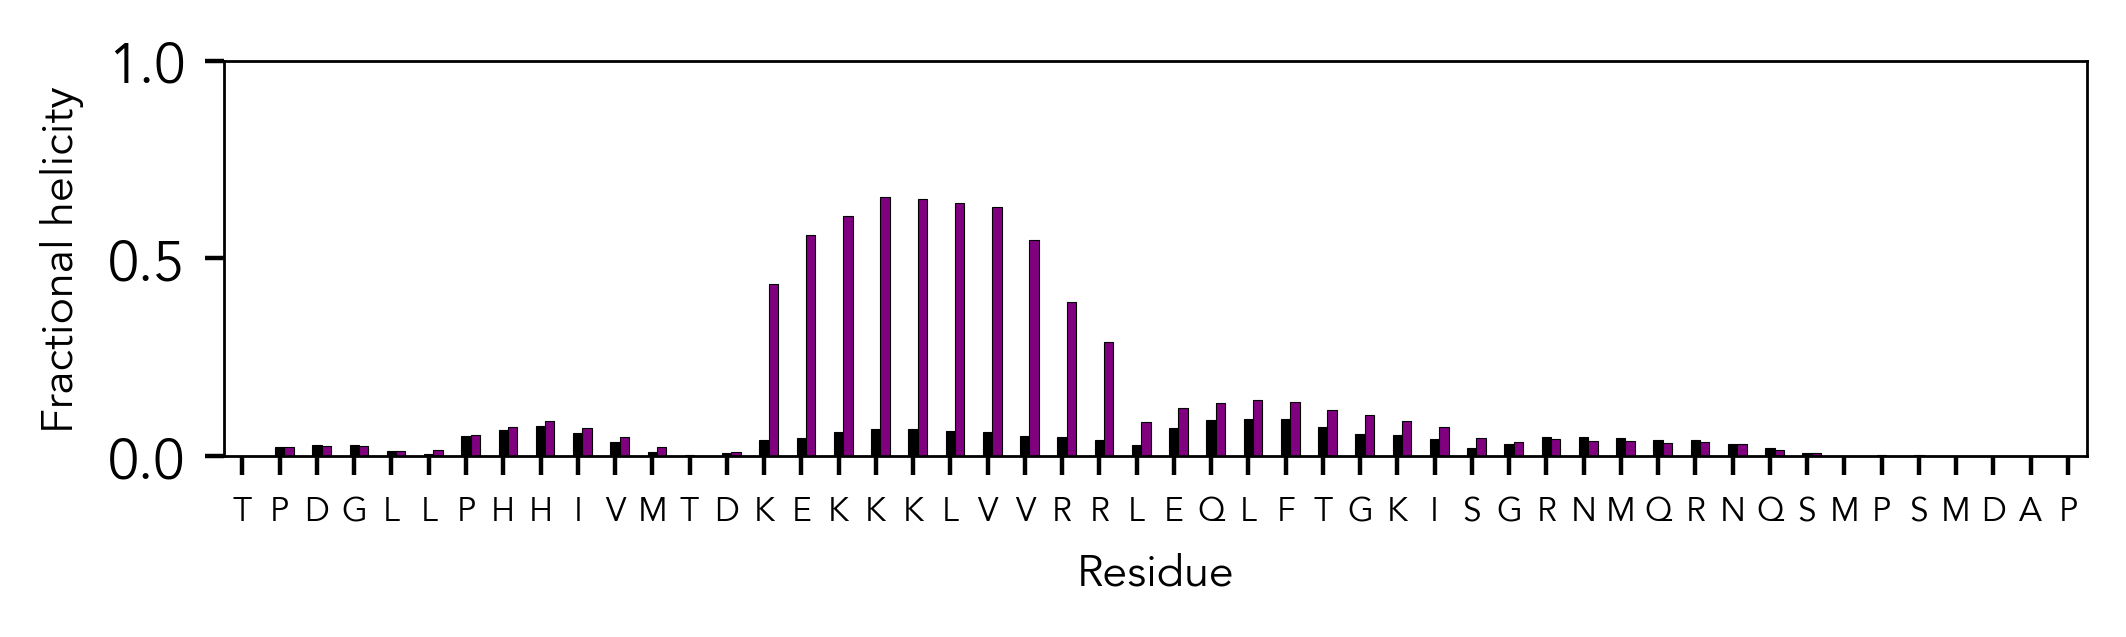

In [8]:
figure(num=None, figsize=(5.5, 1.7), dpi=200, facecolor='w', edgecolor='k')
ax = plt.gca()


offset=0
offset_stepsize=0.25
for n in ['WT','KKK_AAA']:
    residue_idx = np.arange(1,len(dssp_full[n])+1)
    plt.bar(residue_idx+offset, dssp_full[n], width=offset_stepsize, color=color_set[n], edgecolor='k',linewidth=0.2,label=n)
    offset = offset+offset_stepsize
    
plt.ylim([0,1])    
plt.xticks(residue_idx, 'TPDGLLPHHIVMTDKEKKKLVVRRLEQLFTGKISGRNMQRNQSMPSMDAP',fontsize=6)
print('')
#plt.legend(frameon=False,fontsize=8)
plt.xlim([1-0.5,residue_idx[-1]+0.5])
plt.ylabel(r'Fractional helicity', fontsize=8)
plt.xlabel('Residue',fontsize=8)
plt.tight_layout()
plt.savefig('figures/dssp_h_raw.pdf')


## Plot radius of gyration distributions
Plot $R_g$ distribution for simulations along with with the AFRC distribution.

AFRC Rg for WT: 17.679004403628532
AFRC Rg for KKK_AAA: 17.679004403628532


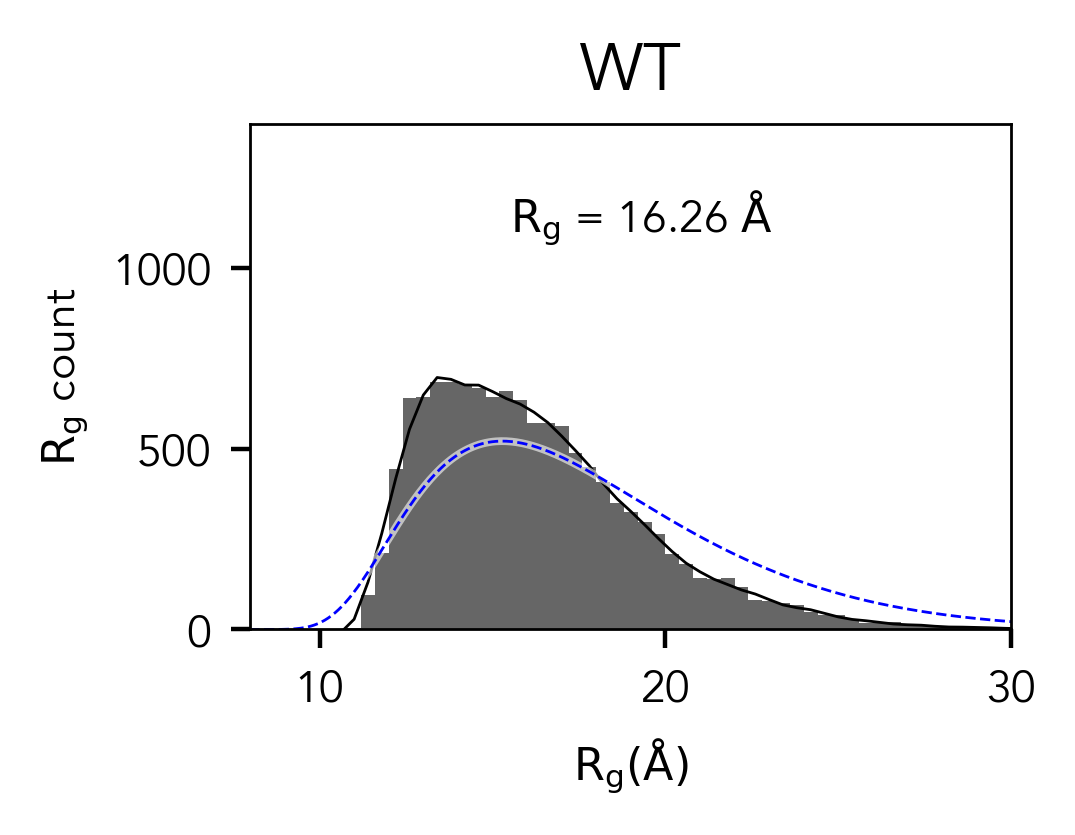

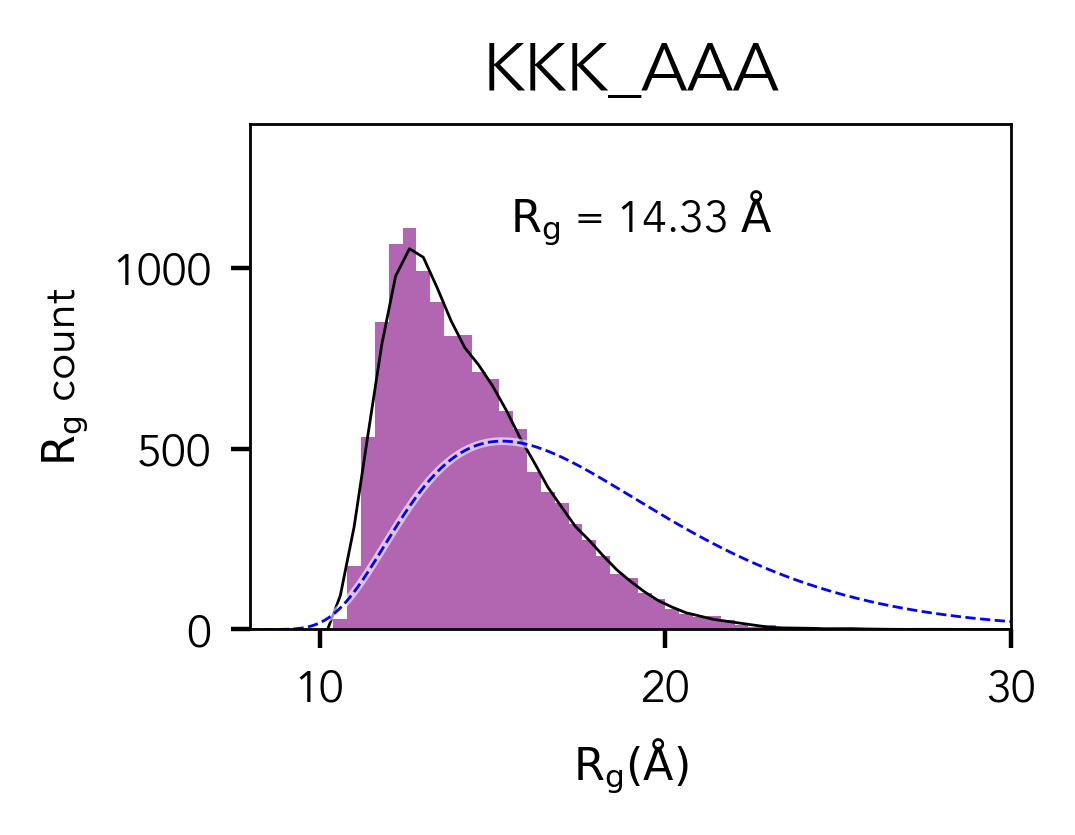

In [10]:
for n in names:
    figure(num=None, figsize=(2.8, 2.2), dpi=200, facecolor='w', edgecolor='k')
    ax = plt.gca()
    
    plt.title(n)
    
    # read data bins
    bin_size=0.4
    bins = np.arange(0,70+bin_size*0.5,bin_size)

    # do histogramming
    [a,b] = np.histogram(rg[n], bins)

    # plot read data
    plt.bar(bins[:-1]+bin_size*0.5, a, width=bin_size, color=color_set[n], alpha=0.6)

    # plot smoothed line to gude eye
    plt.plot(bins[:-1]+bin_size*0.5, savgol_filter(a,9,3),'-k',linewidth=0.5)

    # calculate mean and format
    mean_rg_string = f"{np.mean(rg[n]):.2f}"
    
    # sample same counts from AFRC distribution
    rg_afrc_dist = AnalyticalFRC(sequences['WT']).get_radius_of_gyration_distribution()
    
    # read data bins
    afrc_bin_size = rg_afrc_dist[0][1] - rg_afrc_dist[0][0]

    # correct for differences is sample size and bin size (note 1 is because some of PDF=1)
    count_factor = len(rg[n])/1 * (bin_size/afrc_bin_size)

    # plot AFRC distribution
    plt.plot(rg_afrc_dist[0], rg_afrc_dist[1]*count_factor,'-w',linewidth=1.4, alpha=0.6)
    plt.plot(rg_afrc_dist[0], rg_afrc_dist[1]*count_factor,'--b',linewidth=0.5)    
    print(f"AFRC Rg for {n}: {AnalyticalFRC(sequences['WT']).get_mean_radius_of_gyration()}")
    
    plt.text(15.5, 1100, r'$\rm{R_g}$ = ' + mean_rg_string + " "+ r'$\rm{\AA}$', fontsize=8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.xlabel(r'$\rm{R_g} (\AA)$',fontsize=8)
    plt.ylabel(r'$\rm{R_g}$ count',fontsize=8)
    
    plt.xlim([8,30])
    plt.ylim([0,1400])
    plt.tight_layout()
    plt.savefig(f'figures/rg_{n}.pdf')
    

    

# Bonus analysis 
Average radii of gyration from independent simulations (used to indicate reasonable samploing

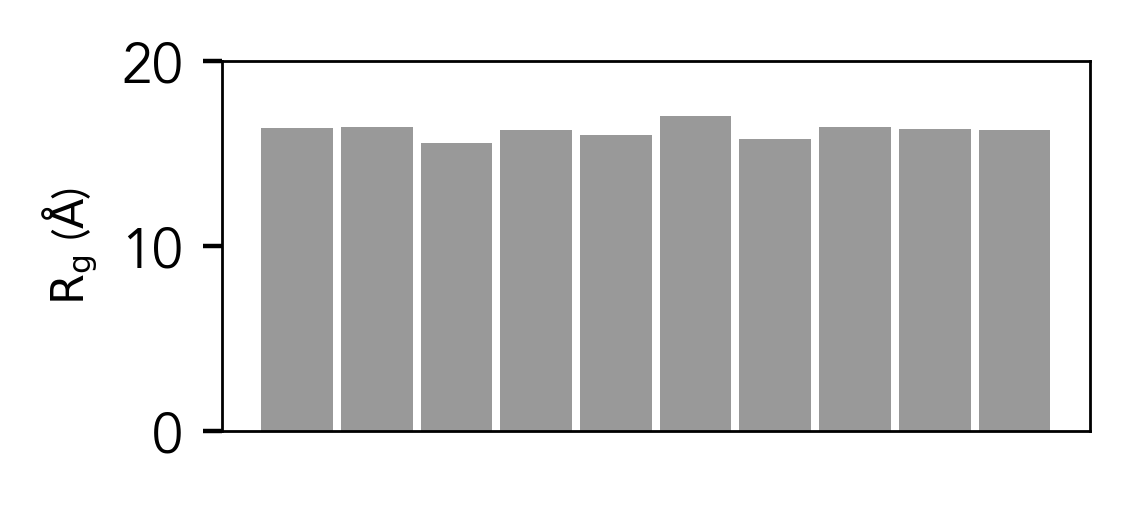

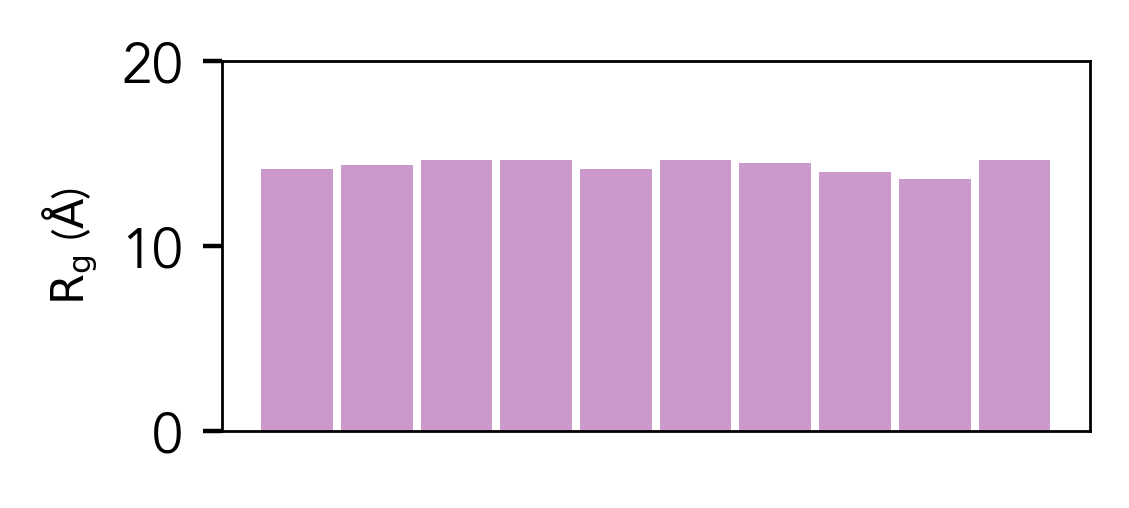

In [31]:
for n in names:

    independent_rgs = np.loadtxt(f'data/full/{n}/individual_rg.csv')
    figure(num=None, figsize=(2.8, 1.2), dpi=200, facecolor='w', edgecolor='k')
    plt.bar(np.arange(1,len(independent_rgs)+1), independent_rgs, color=color_set[n], alpha=0.4, width=0.9)
    plt.xticks([])
    plt.ylim([0,20])
    plt.ylabel(r'$\rm{R_g}$ ($\rm\AA$)', fontsize=8)
    plt.savefig(f'figures/convergence_rg_{n}.pdf')